# Trabalho A2 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data_updated.csv` disponibilizado no e-class. O arquivo contém as variáveis `week`, `volume`, `inv` e `users`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.


### Integrantes
- Guilherme Carvalho
- Guilherme Buss
- Gustavo Bianchi
- João Gabriel
- Luís Felipe Marciano
- Vinícius Nascimento

### Objetivos
- Carregar e analisar data.csv
- Implementar baselines (mean, naive, seasonal naive, drift)
- Testar transformações (Box-Cox / log)
- Decompor série em tendência e sazonalidade
- Criar covariáveis (tempo, dummies sazonais, sen/cos, lags, rollings)
- Ajustar modelos de regressão linear múltipla
- Diagnosticar resíduos (ACF, Ljung-Box)
- Comparar usando métricas: MAE, RMSE, MAPE, MASE

---

## **Importação das bibliotecas**

In [46]:
# básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from datetime import datetime

# para modelos 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# para decomposição e testes
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox

---

## **Pré-visualização dos dados**

In [47]:
df = pd.read_csv("data_updated.csv")

df['week'] = pd.to_datetime(df['week']) # converter week para datetime
df = df.sort_values('week').reset_index(drop=True) # ordenar por data e reset index
df = df.set_index('week')

# checar informações
print('Tamanho da série:', len(df))
print(df.head(10))

Tamanho da série: 157
            volume       inv   users
week                                
2022-10-31    0.38  1.609882   6.500
2022-11-07    0.47  1.880548   7.061
2022-11-14    0.32  2.297810   5.875
2022-11-21    1.69  5.623875  24.238
2022-11-28    1.23  1.473418   7.648
2022-12-05    0.77  0.691911   4.105
2022-12-12    0.49  0.335866   2.060
2022-12-19    0.14  0.182806   0.655
2022-12-26    0.39  0.182695   0.778
2023-01-02    0.33  0.121898   0.808


---

## **Análise inicial dos dados de `volume`**

Antes de iniciar a modelagem, realizamos uma análise descritiva da variável `volume` para compreender sua forma e dispersão de suas amostras.

#### **Centralidade**

* *Média:* O valor médio de `volume` ao longo de todo o período. 
* *Mediana:* O valor que divide a série em duas metades, mais robusta a outliers.

#### **Dispersão**

* *Desvio Padrão:* Grau de dispersão médio dos dados em relação à média.
* *Variância:* É o quadrado do desvio padrão. 

#### **Forma da Distribuição**

* *Assimetria (Skewness):* Mede a falta de simetria da distribuição.
    * `~ 0`: Distribuição aproximadamente simétrica.
    * `> 0`: Assimetria positiva (à direita). A cauda direita da distribuição é mais longa, e a média tende a ser maior que a mediana.
    * `< 0`: Assimetria negativa (à esquerda). A cauda esquerda é mais longa, e a média tende a ser menor que a mediana.

#### **Valores Extremos**

* *Mínimo e Máximo:* Os menores e maiores valores de `volume` observados na série. Ajudam a entender a amplitude total dos dados.

In [48]:
# Métricas iniciais
mean = np.mean(df["volume"])
median = np.median(df["volume"])

std = np.std(df["volume"])
variance = np.var(df["volume"])

skewness = stats.skew(df["volume"])

max_df = np.max(df["volume"])
min_df = np.min(df["volume"])
range_df = max_df - min_df

In [49]:
print("- VARIÁVEL VOLUME - " * 5)
print("-" * 100)

print("--- Tendência Central ---")
print(f"{'Média:':<25} {mean:,.2f}")
print(f"{'Mediana:':<25} {median:,.2f}")

print("\n--- Dispersão ---")
print(f"{'Desvio Padrão:':<25} {std:,.2f}")
print(f"{'Variância:':<25} {variance:,.2f}")

print("\n--- Forma da Distribuição ---")
print(f"{'Assimetria (Skewness):':<25} {skewness:.2f}")

print("\n--- Valores Extremos ---")
print(f"{'Valor Mínimo:':<25} {min_df:,.2f}")
print(f"{'Valor Máximo:':<25} {max_df:,.2f}")
print(f"{'Amplitude (Range):':<25} {range_df:,.2f}")

print("-" * 100)

- VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - 
----------------------------------------------------------------------------------------------------
--- Tendência Central ---
Média:                    4.82
Mediana:                  3.25

--- Dispersão ---
Desvio Padrão:            5.15
Variância:                26.48

--- Forma da Distribuição ---
Assimetria (Skewness):    1.46

--- Valores Extremos ---
Valor Mínimo:             0.14
Valor Máximo:             24.52
Amplitude (Range):        24.38
----------------------------------------------------------------------------------------------------


A análise nos mostra que a série de volume não é 'bem comportada'. Ela tem uma forte assimetria positiva e alta volatilidade. Futuramente, veremos através do gráfico que o grande causador disso seria reflexo da presença de picos em valores elevados. Essa observação que fizemos sugere a possível necessidade de uma transformação de variável (como a logarítmica) antes da modelagem, o que pode estabilizar a variância e tornar a distribuição mais simétrica, o que tende a melhorar o ajuste e o poder preditivo de modelos de regressão.

---

## **Análise de *Estacionariedade* da série temporal**

A estacionariedade é uma premissa fundamental para muitos modelos de séries temporais. Uma série é dita estacionária se suas propriedades estatísticas, como média e variância, são constantes ao longo do tempo. Nesta seção, investigamos se a série de `volume` atende a essa premissa através de análise visual e Função de Autocorrelação (ACF).

### **Inspeção Visual**

Verificaremos através de visualizações se a série é ou não estacionária:

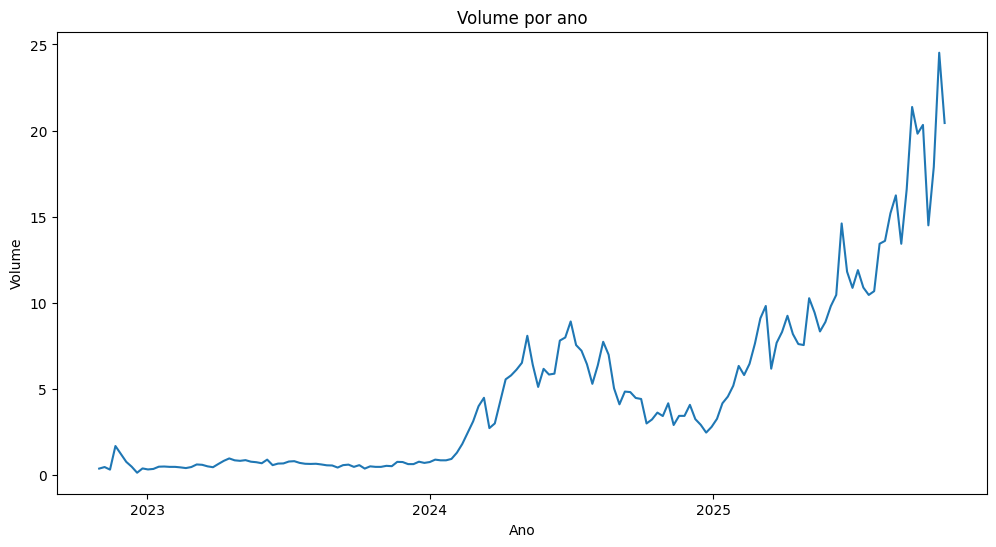

In [50]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['volume'])

# mostrar apenas os anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Volume")
plt.title("Volume por ano")
plt.show()

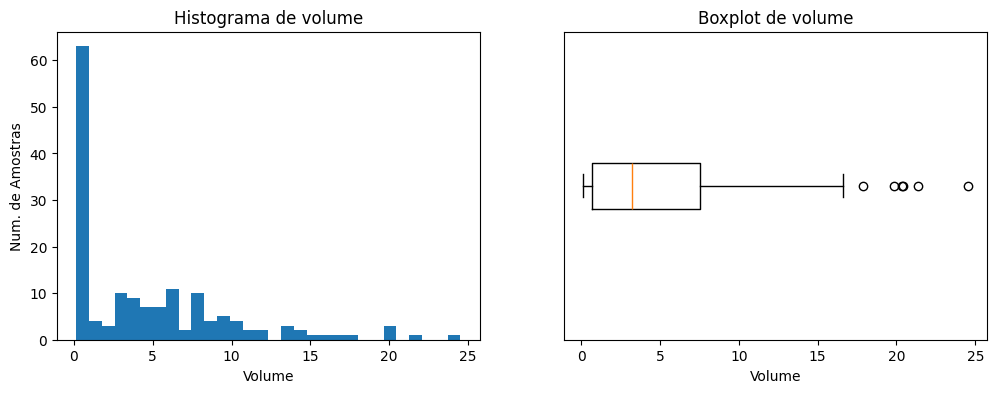

In [51]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['volume'].dropna(), bins=30)
plt.title('Histograma de volume')
plt.xlabel("Volume")
plt.ylabel("Num. de Amostras")

plt.subplot(1,2,2)
plt.boxplot(df['volume'].dropna(), vert=False)
plt.title('Boxplot de volume')
plt.yticks([])
plt.xlabel("Volume")
plt.show()

Os gráficos sugerem fortemente que a série é não-estacionária, já que:
1.  *Há tendência de crescimento:* Temos uma tendência de alta no `volume` ao longo do período analisado, indicando que a média da série não é constante.
2.  *Variância inconstante:* As oscilações do `volume` aumentam conforme o nível da série sobe, com vales e picos mais distantes.

### **Análise da Série Diferenciada**

Dado que a análise inicial indicou que a série `volume` não é estacionária — possivelmente devido a uma tendência ou variações na média ao longo do tempo —, aplicamos a técnica de diferenciação. Este processo visa estabilizar a média da série, tornando-a estacionária.

O objetivo agora é avaliar se a diferenciação foi bem-sucedida. Para isso, realizaremos novamente a inspeção visual e a análise da Função de Autocorrelação (ACF) na série transformada. Esperamos observar que a série diferenciada não exiba mais tendências claras e que sua autocorrelação decaia rapidamente para zero.

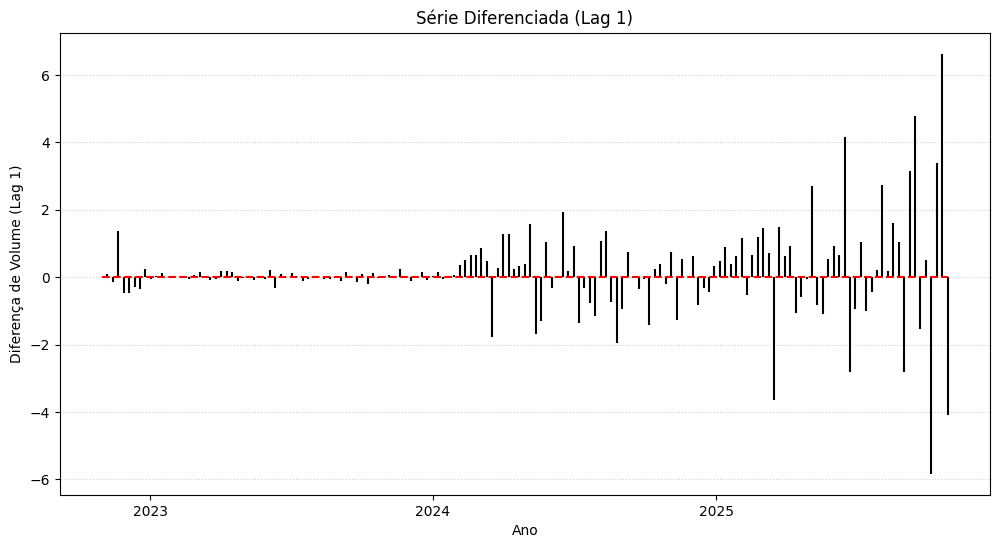

In [52]:
# Diferenciação (Lag 1)
df['volume_diff'] = np.where(df['volume'].diff(1) != np.nan, df['volume'].diff(1), 0)

plt.figure(figsize=(12, 6))

(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

A série diferenciada (Lag 1) mostra que os valores ainda apresentam flutuações grandes ao longo do tempo, com oscilações que parecem se intensificar nos períodos mais recentes. Apesar da diferenciação, não há uma estabilização em torno da linha zero, o que indica que a série ainda pode carregar estruturas de dependência temporal não removidas apenas pela primeira diferenciação.

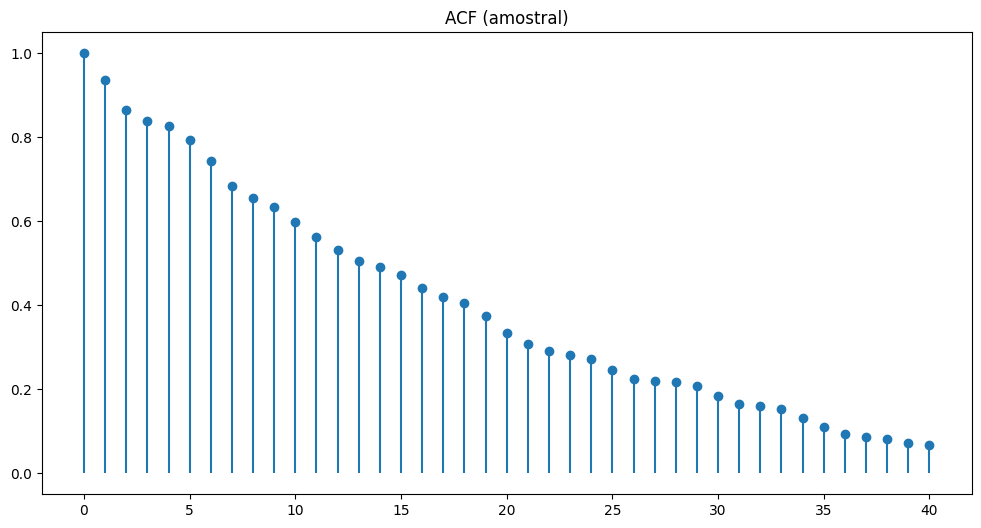

In [53]:
lag_acf = acf(df['volume'].dropna(), nlags=40, fft=False)
plt.figure(figsize=(12,6))
plt.stem(range(len(lag_acf)), lag_acf, basefmt=' ')
plt.title('ACF (amostral)')
plt.show()

Reforçando essa interpretação, o gráfico da ACF exibe uma decadência lenta e gradual das autocorrelações ao longo das defasagens, o que é característica de séries com forte dependência e possível não estacionariedade.

Dessa forma, pode ser necessária a aplicação de mais diferenciações ou transformações adicionais para garantir a estacionariedade antes da modelagem (por exemplo, em ARIMA).

### **Usando Log-Transformação: Será?**

O logaritmo estabiliza a variância, fazendo com que a série se comporte de forma mais homogênea e facilitando a modelagem, especialmente em séries com tendência de crescimento exponencial. Como nossa série tem crescimento aparentemente exponencial, podemos fazer um teste de resíduo após a mudança e observar se vale a pena utilizar uma log-transformação.

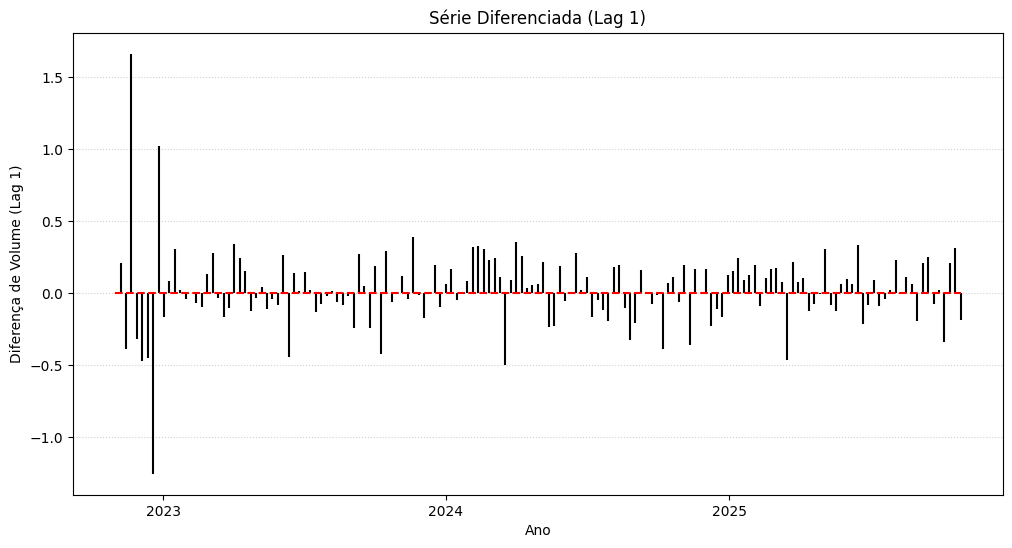

In [54]:
df['volume_log'] = np.log(df['volume']) 
df['volume_log_diff'] = np.where(df['volume_log'].diff(1) != np.nan, df['volume_log'].diff(1), 0)

#print(df.head())
plt.figure(figsize=(12, 6))
(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_log_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

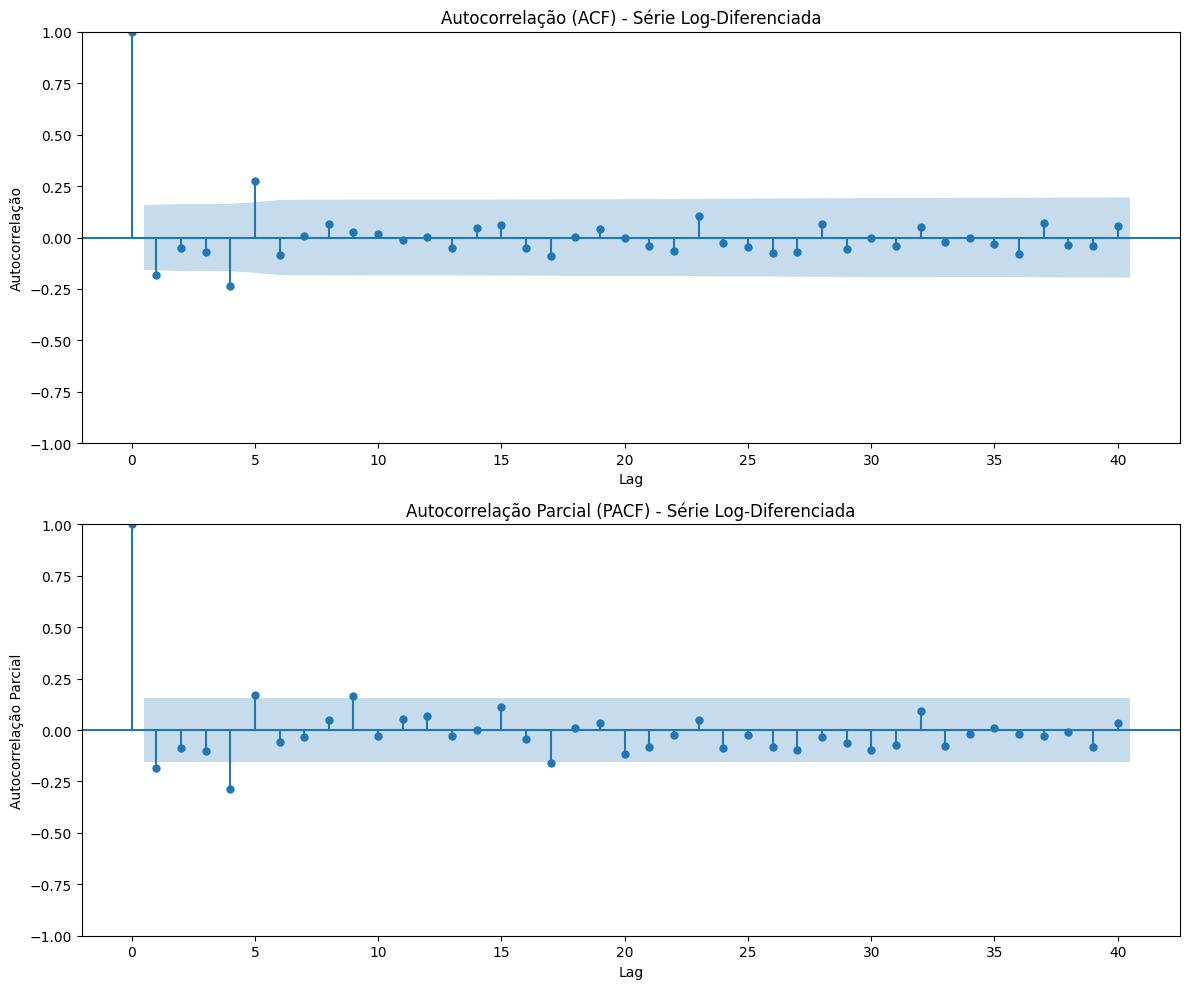

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF
sm.graphics.tsa.plot_acf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax1)
ax1.set_title('Autocorrelação (ACF) - Série Log-Diferenciada')
ax1.set_ylabel("Autocorrelação")
ax1.set_xlabel("Lag")

# PACF
sm.graphics.tsa.plot_pacf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF) - Série Log-Diferenciada')
ax2.set_ylabel("Autocorrelação Parcial")
ax2.set_xlabel("Lag")

plt.tight_layout()
plt.show()

As flutuações da série transformada tornaram-se visivelmente mais regulares. Analisando seus gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF), observamos que a maioria dos lags cai rapidamente dentro do intervalo de confiança. Isso sugere que a transformação foi eficaz em remover a maior parte da estrutura de dependência temporal, tornando a série adequada para modelagem. Adotaremos a transformação logarítmica como um passo padrão antes de ajustar nossos modelos de regressão.

---

## **Decomposição em Tendência, Sazonalidade e Resíduos**

Para entender melhor os padrões da série `volume`, realizamos uma decomposição para separar seus três principais componentes:

1.  **Tendência:** O comportamento de longo prazo da série.
2.  **Sazonalidade:** Padrões que se repetem em intervalos fixos.
3.  **Resíduos:** A parte "restante" da série após a remoção da tendência e da sazonalidade.

Utilizamos o método STL (Seasonal-Trend decomposition using LOESS), que é robusto e flexível. Assumimos um período sazonal de 52 semanas, correspondente a um ciclo anual.

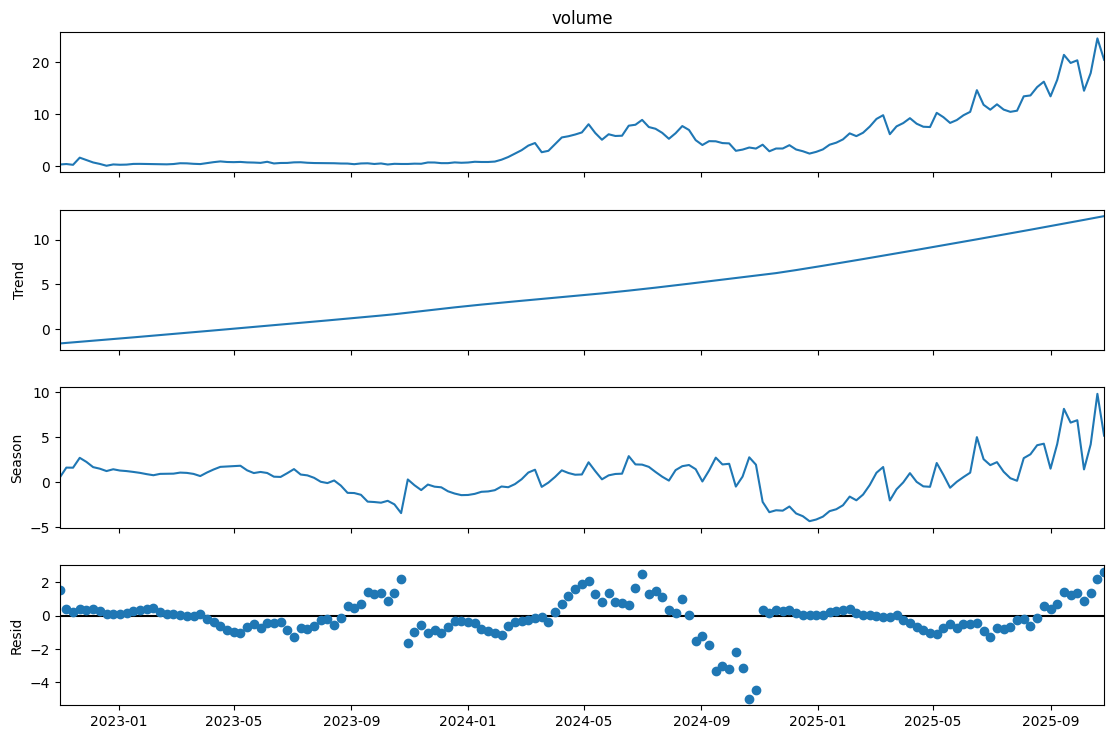

In [56]:
# como os dados são semanais, um período sazonal comum é 52 (semanas em um ano)
# vamos usar STL (Seasonal-Trend decomposition using LOESS) que é robusto a outliers
stl = STL(df['volume'], period=52)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.show()

# Extraindo os componentes
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['resid'] = res.resid

A análise do gráfico de decomposição revela:
- **Tendência**: Confirma a tendência de crescimento que observamos visualmente, mostrando um aumento consistente no nível do volume ao longo do tempo.

- **Resíduos**: Os resíduos parecem estar distribuídos em torno de zero, no entanto, a observação de correlação entre os resíduos de diferentes anos (como 2023 e 2025) indica que os resíduos não são totalmente aleatórios. Essa autocorrelação residual sugere que a decomposição não capturou toda a dependência temporal da série, necessitando de modelos mais explícitos.

- **Variância**: A variância nos resíduos ainda parece aumentar com o tempo (Heteroscedasticidade), reforçando a decisão de usar a transformação logarítmica para estabilizá-la na modelagem.

A presença de tendência e sazonalidade justifica porque devemos incluir elas explicitamente em nossos modelos de regressão para capturar a dinâmica da série.

---
## **Métricas de Avaliação e Estratégia de Validação** 

Para avaliar e comparar o desempenho dos modelos, utilizaremos as seguintes métricas, calculadas na escala original (Volume):

  * **Mean Absolute Error (MAE):** Mede a média dos erros absolutos. É fácil de interpretar, pois está na mesma unidade da variável de resposta.
  * **Root Mean Squared Error (RMSE):** Similar ao MAE, mas penaliza erros maiores com mais intensidade. Também está na unidade da variável original.
  * **Mean Absolute Percentage Error (MAPE):** Expressa o erro como uma porcentagem, útil para comparar a precisão entre séries de diferentes escalas.

### Estratégia de Validação: *Rolling Forecast* (Walk-Forward)

Para uma avaliação justa e para simular a aplicação real de *forecasting* de curto prazo, utilizaremos a **Validação *Walk-Forward*** com um **Horizonte de Previsão ($H$) de 4 semanas**.

  * **Lógica:** Em vez de fazer uma única previsão para 52 semanas, usaremos as **últimas 52 semanas** da série como nosso período de validação. Dentro desse período:
    1.  O modelo será **treinado** em todos os dados *anteriores* ao ponto de partida da previsão.
    2.  O modelo fará uma previsão para o **próximo horizonte de 4 semanas ($H=4$)**.
    3.  A janela de treino será **avançada em 4 semanas**, e o processo será repetido.
  * **Vantagem:** Essa estratégia garante que, em cada passo, o modelo utilize os dados mais recentes para prever o futuro imediato, imitando exatamente como ele seria usado na vida real.
  * **Transformação:** Como nossos modelos de regressão preverão o logaritmo do volume, todas as previsões serão transformadas de volta para a escala original (usando a exponencial) antes de calcular as métricas agregadas.


In [61]:
# Definindo o horizonte de previsão (H) 
H = 4 # 4 semanas (1 mês)

# Divisão Treino vs. Teste de 4 semanas
test_size_H = H
train_df = df.iloc[:-test_size_H]
test_df = df.iloc[-test_size_H:]

# Aplicação da Transformação
y_train = np.log(train_df['volume'])
y_test = np.log(test_df['volume'])

print(f"Treino termina em: {train_df.index[-1]}")
print(f"Teste começa em: {test_df.index[0]} (Horizonte de {H} semanas)")

Treino termina em: 2025-09-29 00:00:00
Teste começa em: 2025-10-06 00:00:00 (Horizonte de 4 semanas)


---
## **Modelos Baseline**

Antes de construir modelos complexos, estabelecemos baselines para termos um ponto de referência de desempenho. Um modelo sofisticado só é útil se superar significativamente um modelo simples. Implementamos:

1.  **Modelo da Média:** Prevê que todos os valores futuros serão a média histórica do conjunto de treino.
2.  **Modelo Naive:** Prevê que o próximo valor será igual ao último valor observado no treino.
3.  **Modelo Seasonal Naive:** Prevê que o valor em um determinado período será igual ao valor observado no mesmo período do ciclo anterior (ex: o volume desta semana será igual ao da mesma semana do ano passado).

Iniciando Walk-Forward Validation:
                     MAE      RMSE       MAPE
Mean            8.139645  9.637635  77.562406
Naive           1.771154  2.506822  17.750156
Seasonal Naive  5.782115  7.421801  58.711960
Drift Method    1.653246  2.281740  17.269189


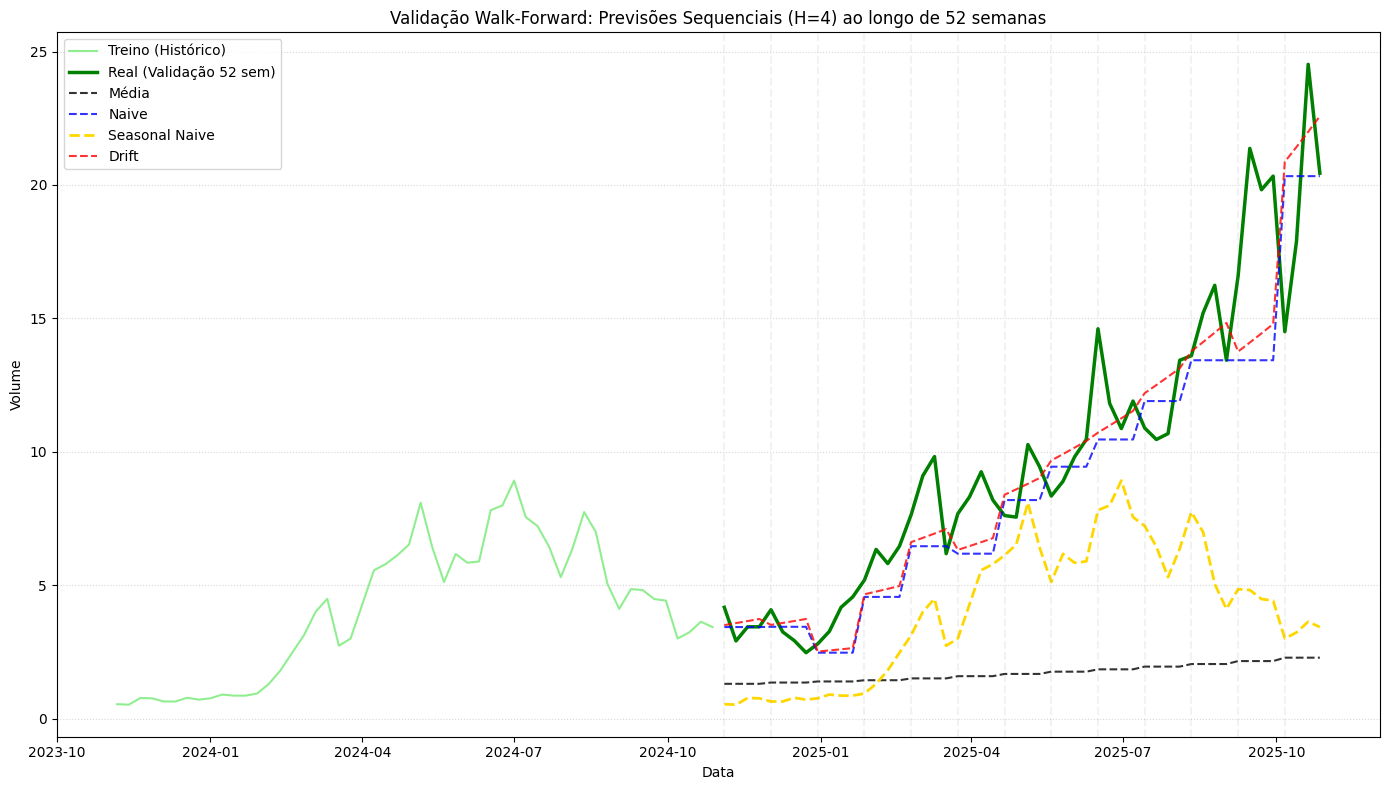

In [ ]:
VALIDATION_SIZE = 52  # Tamanho total do teste (último ano)

# Splits mensais para previsão
n_splits = VALIDATION_SIZE // H
total_len = len(df)
start_validation_idx = total_len - VALIDATION_SIZE

# Dicionários para armazenar as previsões das 52 semanas
all_preds = {
    'Mean': [],
    'Naive': [],
    'Seasonal Naive': [],
    'Drift Method': []
}
all_true_values = []
all_test_dates = []

print(f"Iniciando Walk-Forward Validation:")
for i in range(n_splits):
    # Definir ponto de corte atual (vai de H passos por vez)
    current_cut = start_validation_idx + (i * H)
    
    # Dividindo Treino e Teste para essa interação
    train_df_iter = df.iloc[:current_cut]
    test_df_iter = df.iloc[current_cut : current_cut + H]
    
    # Transformação Logarítmica 
    y_train = np.log(train_df_iter['volume'])
    
    # Baselines para os próximos H passos
    # A. Média (só a média geral mesmo)
    pred_mean = np.full(H, y_train.mean())
    
    # B. Naive (Último valor do treino atual)
    pred_naive = np.full(H, y_train.iloc[-1])
    
    # C. Seasonal Naive (O valor de 52 semanas atrás relativo ao corte atual)
    pred_seasonal_naive = y_train.iloc[-52 : -52 + H].values
    
    # D. Drift (Naive com drift)
    slope = (y_train.iloc[-1] - y_train.iloc[0]) / (len(y_train) - 1)
    pred_drift = y_train.iloc[-1] + np.arange(1, H + 1) * slope
    
    # Reverter Transformação (Exp)
    all_preds['Mean'].extend(np.exp(pred_mean))
    all_preds['Naive'].extend(np.exp(pred_naive))
    all_preds['Seasonal Naive'].extend(np.exp(pred_seasonal_naive))
    all_preds['Drift Method'].extend(np.exp(pred_drift))
    
    # Armazenar valores reais e datas para plotagem
    all_true_values.extend(test_df_iter['volume'].values)
    all_test_dates.extend(test_df_iter.index)

results = {}
y_test_full = np.array(all_true_values)

for name, preds in all_preds.items():
    preds_arr = np.array(preds)
    results[name] = {
        'MAE': mean_absolute_error(y_test_full, preds_arr),
        'RMSE': np.sqrt(mean_squared_error(y_test_full, preds_arr)),
        'MAPE': mean_absolute_percentage_error(y_test_full, preds_arr) * 100
    }

results_df = pd.DataFrame(results).T
print(results_df)

# Plotagem
plt.figure(figsize=(14, 8))

# Plotar o final do Treino e o Teste
context_window = 52 
train_plot_idx = df.iloc[:start_validation_idx].index[-context_window:]
train_plot_val = df.iloc[:start_validation_idx]['volume'].values[-context_window:]

plt.plot(train_plot_idx, train_plot_val, label='Treino (Histórico)', color='lightgreen')
plt.plot(all_test_dates, y_test_full, label='Real (Validação 52 sem)', color='green', linewidth=2.5)

# Plotar as Previsões (Concatenadas)
plt.plot(all_test_dates, all_preds['Mean'], label='Média', linestyle='--', color='black', alpha=0.8)
plt.plot(all_test_dates, all_preds['Naive'], label='Naive', linestyle='--', color='blue', alpha=0.8)
plt.plot(all_test_dates, all_preds['Seasonal Naive'], label='Seasonal Naive', linestyle='--', color='gold', linewidth=2)
plt.plot(all_test_dates, all_preds['Drift Method'], label='Drift', linestyle='--', color='red', alpha=0.8)

plt.title(f'Validação Walk-Forward: Previsões Sequenciais (H={H}) ao longo de {VALIDATION_SIZE} semanas')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.5)

for i in range(0, VALIDATION_SIZE, H):
    plt.axvline(x=all_test_dates[i], color='gray', linestyle='--', alpha=0.1)

plt.tight_layout()
plt.show()

### **Resultados dos Baselines (Walk-Forward Validation $H=4$)**

A tabela abaixo apresenta os resultados agregados da validação cruzada temporal (*Rolling Forecast*), simulando previsões mensais (4 semanas) ao longo do último ano.

| Modelo | MAE | RMSE | MAPE (%) |
| :--- | :--- | :--- | :--- |
| Mean | 8.1396 | 9.6376 | 77.56% |
| Naive | 1.7711 | 2.5068 | 17.75% |
| Seasonal Naive | 5.7821 | 7.4218 | 58.71% |
| **Drift Method** | **1.6532** | **2.2817** | **17.27%** |

### **Análise dos Resultados:**

O modelo **Drift Method** (Naive com tendência) apresentou o melhor desempenho em todas as métricas (**RMSE 2.28** e **MAPE 17.27%**), seguido de muito perto pelo modelo **Naive**. Isso indica uma característica crucial da nossa série: a dependência de curto prazo e a tendência recente são preditores muito mais fortes do que a sazonalidade pura.

* **Seasonal Naive:** O erro alto do Seasonal Naivemostra que, embora exista sazonalidade, o nível do volume muda significativamente de um ano para o outro. Acaba que ele não é um bom baseline para esse caso
* **Drift Method** Para um horizonte curto de 4 semanas, o volume da última semana carrega a informação mais vital sobre o nível atual da série. O baseline com tendência leva uma ligeira vantagem pois consegue capturar a inclinação de crescimento da série, projetando essa tendência para o futuro imediato.
* **Logo...:** Adotaremos o **Drift Method** como nosso*baseline oficial a ser superado. Qualquer modelo complexo (Regressão, ARIMA) precisará apresentar um RMSE inferior a **2.28** para justificar sua complexidade.

# Preparação de Dados para Modelagem Preditiva
### Criando Recursos Temporais (Time-Based Features)

Antes de aplicar qualquer modelo, é necessário que enriqueçamos a nossa série temporal. O fato de termos apenas week e volume como features é definitivamente o principal limitador de qualquer modelo que não seja um simples baseline.

Assim, iremos adicionar informações adicionais para "aprender" a sazonalidade, a tendência e a dependência de curto prazo, como:

| Recurso | Descrição | Utilidade
| :--- | :--- | :--- |
| Sazonalidade | ```week_of_year, month, quarter``` | Captura o padrão repetitivo |
| Tendência | ```time_index``` | Uma contagem simples (ex: 1,2,3,…, N) | 
| Dependência Temporal | Lags de ```volume``` | Para ver a dependência do volume de hoje com o volume de ontem | 



In [ ]:
df_prepared = df.drop(columns=["trend", "seasonal", "resid"])
#print(df_prepared[0:20])

df_prepared["week_of_year"] = df_prepared.index.isocalendar().week.astype(int)
df_prepared["month"] = df_prepared.index.month
df_prepared["quarter"] = df_prepared.index.quarter

df_prepared["time_index"] = np.arange(len(df_prepared))

# --- Feature de Lag (Dependência Temporal) ---
# lag 1
df_prepared["lag_volume_log_1"] = df_prepared["volume_log"].shift(1)

# Média do log-volume para imputação (evitar o "nan" no primeiro dia)
mean_log_volume = df_prepared['volume_log'].mean()
df_prepared['lag_volume_log_1' ] = df_prepared['lag_volume_log_1' ].fillna(mean_log_volume)

df_prepared[['volume_diff', 'volume_log_diff']] = df_prepared[['volume_diff', 'volume_log_diff']].fillna(0)
print(df_prepared.head(5))

            volume       inv   users  volume_diff  volume_log  \
week                                                            
2022-10-31    0.38  1.609882   6.500         0.00   -0.967584   
2022-11-07    0.47  1.880548   7.061         0.09   -0.755023   
2022-11-14    0.32  2.297810   5.875        -0.15   -1.139434   
2022-11-21    1.69  5.623875  24.238         1.37    0.524729   
2022-11-28    1.23  1.473418   7.648        -0.46    0.207014   

            volume_log_diff  week_of_year  month  quarter  time_index  \
week                                                                    
2022-10-31         0.000000            44     10        4           0   
2022-11-07         0.212561            45     11        4           1   
2022-11-14        -0.384412            46     11        4           2   
2022-11-21         1.664163            47     11        4           3   
2022-11-28        -0.317714            48     11        4           4   

            lag_volume_log_1  
w

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Definindo o target (y) e as features (X)
y = df_prepared['volume_log']
features = ['time_index', 'week_of_year', 'month', 'quarter', 'lag_volume_log_1'] 
X = df_prepared[features]

X_encoded = pd.get_dummies(X, columns=['week_of_year', 'month', 'quarter'], drop_first=True)

# Divisão (com o teste size de 52, 1 ano)
X_train = X_encoded.iloc[:-test_size]
X_test = X_encoded.iloc[-test_size:]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]

# Inicializando o Modelo de Regressão Linear do sklearn
model = LinearRegression()
model.fit(X_train, y_train)

# Encontra os resíduos no conjunto de treino
predictions_on_train_log = model.predict(X_train)
residuals_log = y_train - predictions_on_train_log

# previsòes
y_pred_log = model.predict(X_test)

# Inclui os resíduos aleatórios
bootstrap_forecasts = []
for i in range(1000):
    # Amostra aleatória dos resíduos
    resampled_residuals = np.random.choice(residuals_log, size=len(X_test), replace=True)
    
    # Adiciona os resíduos à previsão e guarda
    forecast_log_boot = y_pred_log + resampled_residuals
    bootstrap_forecasts.append(np.exp(forecast_log_boot))

# Calcula os limites do IC
bootstrap_forecasts = np.array(bootstrap_forecasts)
lower_bound = np.percentile(bootstrap_forecasts, 100 * (0.025), axis=0)
upper_bound = np.percentile(bootstrap_forecasts, 100 * (0.975), axis=0)

# voltando a forma com exponencial para plot
y_pred_orig = np.exp(y_pred_log)
y_test_orig = np.exp(y_test)

# as Métricas (olhar se melhor que baselines)
mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

print(f"--- Resultados da Regressão Múltipla (MLR) ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

--- Resultados da Regressão Múltipla (MLR) ---
MAE: 2.4749
RMSE: 3.1532
MAPE: 31.54%


## Plot das Previsões

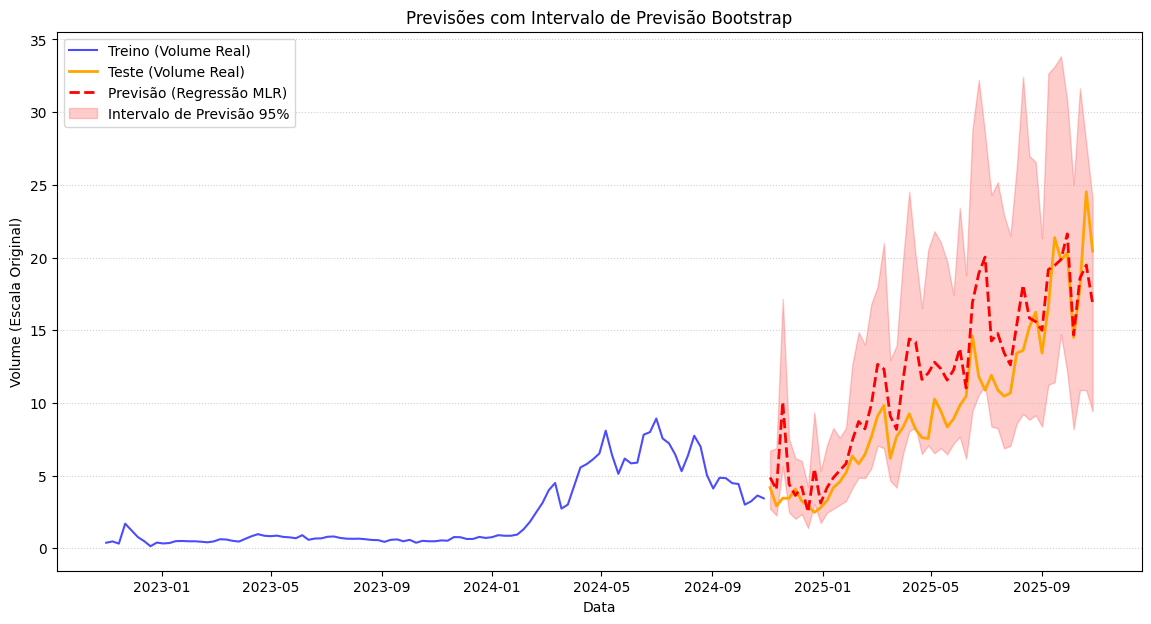

In [ ]:
predictions_series = pd.Series(y_pred_orig, index=test_df.index)

plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df['volume'], label='Treino (Volume Real)', color='blue', alpha=0.7)
plt.plot(test_df.index, test_df['volume'], label='Teste (Volume Real)', color='orange', linewidth=2)

plt.plot(predictions_series.index, predictions_series.values, 
         label='Previsão (Regressão MLR)', color='red', linestyle='--', linewidth=2)

plt.fill_between(predictions_series.index, lower_bound, upper_bound, 
                 color='red', alpha=0.2, label='Intervalo de Previsão 95%')

plt.title('Previsões com Intervalo de Previsão Bootstrap')
plt.xlabel('Data')
plt.ylabel('Volume (Escala Original)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

## Análise dos Resíduos

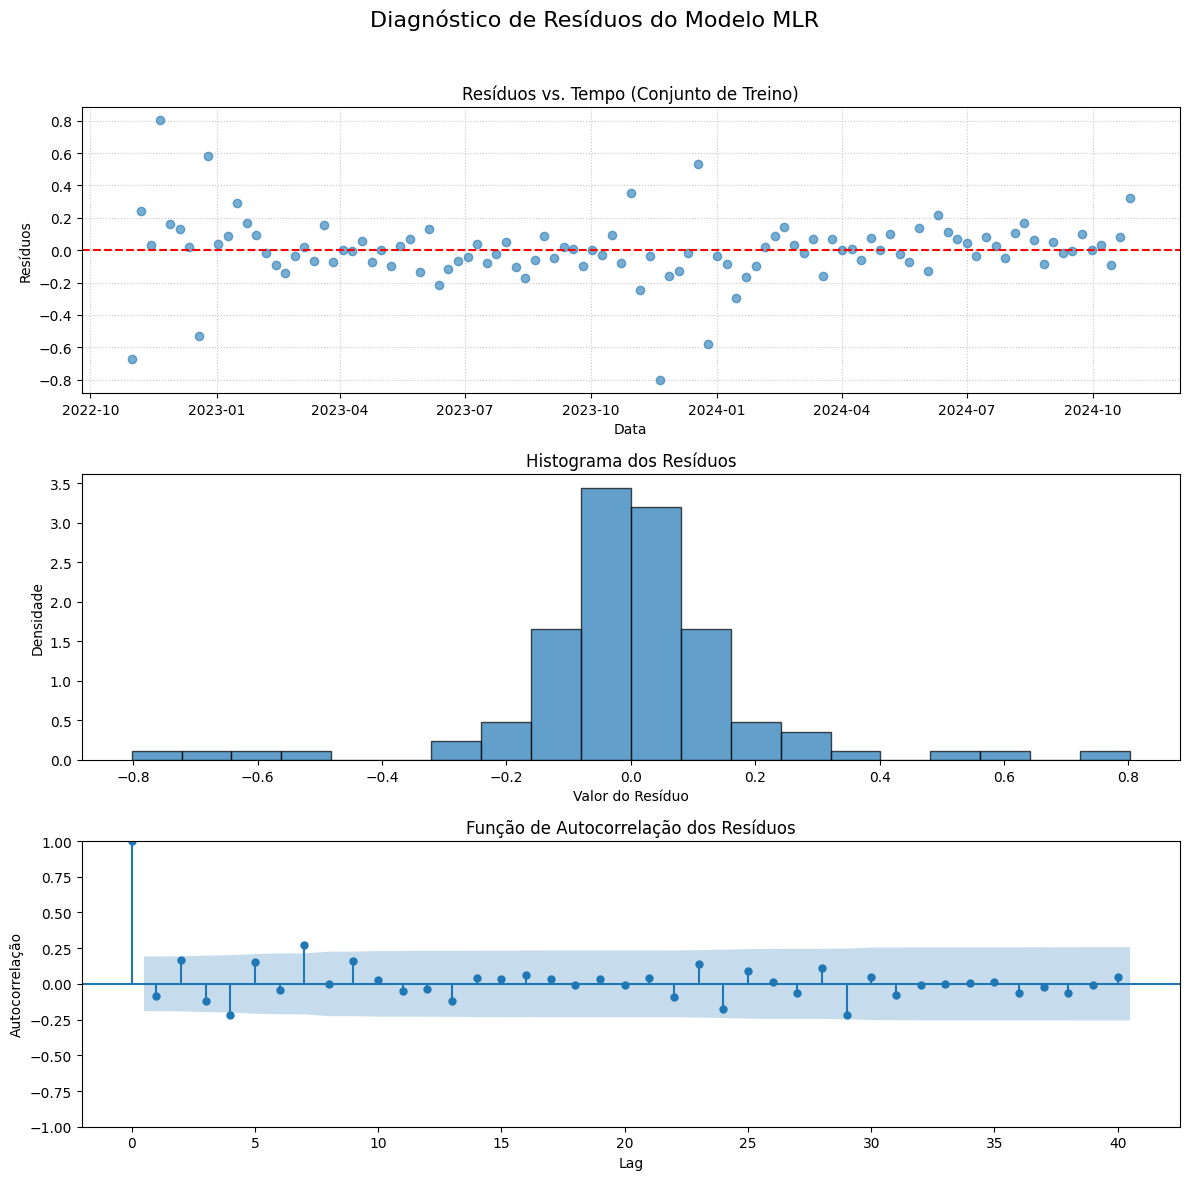


Teste de Ljung-Box para Autocorrelação dos Resíduos
      lb_stat  lb_pvalue
10  25.154754   0.005060
20  28.563429   0.096718
30  47.624699   0.021603
40  50.404194   0.125383


In [ ]:
residuos = y_train - model.predict(X_train)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR', fontsize=16)

# Resíduos ao Longo do Tempo
axs[0].plot(residuos.index, residuos, marker='o', linestyle='None', alpha=0.6)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True, linestyle=':', alpha=0.7)

# Histograma dos resíduos
axs[1].hist(residuos, bins=20, density=True, edgecolor='k', alpha=0.7)
axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')

# Função de autocorrelação dos resíduos
sm.graphics.tsa.plot_acf(residuos, lags=40, ax=axs[2])
axs[2].set_title('Função de Autocorrelação dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste de Ljung-Box para autocorrelação
ljung_box_results = acorr_ljungbox(residuos, lags=[10, 20, 30, 40], return_df=True)
print("\nTeste de Ljung-Box para Autocorrelação dos Resíduos")
print(ljung_box_results)

O primeiro gráfico mostra que: **1 (ponto positivo)-** os resíduos parecem estar distribuídos em torno da linha 0, não apresentando tendência de crescimento ou decrescimento; e **2 (ponto negativo)-** a variância dos pontos não parece ser constante durante todo o período, violando o princípio da homoscedasticidade.

Já o segundo gráfico, por sua vez, nos mostra uma distribuição dos resíduos que se assemelha a de uma **normal com média 0**, algo desejado em um modelo de regressão linear.

No gráfico de ACF, a autocorrelação em todos os níveis de lag se mostrou dentro ou bem próxima do intervalo de confiança, sinal de um bom ajuste de modelo.

Por fim, e contrastando com o teste de ACF, o teste de Ljung-Box apresentou *p_value* muito pequeno, rejeitando a hipótese nula e indicando o impacto do efeito acumulado das autocorrelações na não-independência dos resíduos. 

## MLR v2

Alterações que serão feitas:

- **Introdução de Features Cíclicas**: Modelar as semanas e os meses com seno e cosseno introduz uma relação de ciclo que não existia antes. Ex.: Mês 12 era considerado distante do mês 1, apesar de estarem próximos no calendário.

- **Lags Adicionais**: Incentiva o aprendizado de dependências de curto e longo prazo.

- **Média Móvel**: Introduzimos uma média móvel do *volume_log* das 4 semanas anteriores, visando captar com mais precisão as tendências locais.

In [ ]:
df_featured = df_prepared.copy()

# Features Cíclicas para sazonalidade
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month']/12.0)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month']/12.0)
df_featured['week_sin'] = np.sin(2 * np.pi * df_featured['week_of_year']/52.0)
df_featured['week_cos'] = np.cos(2 * np.pi * df_featured['week_of_year']/52.0)

# Lags Adicionais
for lag in [2, 3, 4, 52]:
    df_featured[f'lag_volume_log_{lag}'] = df_featured['volume_log'].shift(lag)

# Média Móvel para tendência de curto prazo
df_featured['rolling_mean_4'] = df_featured['volume_log'].shift(1).rolling(window=4).mean()

df_featured = df_featured.fillna(df_prepared['volume_log'].mean())

# Definição das features v2
features_v2 = [
    'time_index', 
    'lag_volume_log_1', 'lag_volume_log_2', 'lag_volume_log_3', 'lag_volume_log_4', 'lag_volume_log_52',
    'month_sin', 'month_cos', 
    'week_sin', 'week_cos',
    'rolling_mean_4'
]

X_v2 = df_featured[features_v2]
y_v2 = df_featured['volume_log']

X_train_v2 = X_v2.iloc[:-test_size]
X_test_v2 = X_v2.iloc[-test_size:]
y_train_v2 = y_v2.iloc[:-test_size]
y_test_v2 = y_v2.iloc[-test_size:]

model_v2 = LinearRegression()
model_v2.fit(X_train_v2, y_train_v2)

# Encontra os resíduos no conjunto de treino
predictions_on_train_log_v2 = model_v2.predict(X_train_v2)
residuals_log_v2 = y_train_v2 - predictions_on_train_log_v2

# previsòes
y_pred_log_v2 = model_v2.predict(X_test_v2)

# Inclui os resíduos aleatórios
bootstrap_forecasts_v2 = []
for i in range(1000):
    # Amostra aleatória dos resíduos
    resampled_residuals_v2 = np.random.choice(residuals_log_v2, size=len(X_test_v2), replace=True)
    
    # Adiciona os resíduos à previsão e guarda
    forecast_log_boot_v2 = y_pred_log_v2 + resampled_residuals_v2
    bootstrap_forecasts_v2.append(np.exp(forecast_log_boot_v2))

# Calcula os limites do IC
bootstrap_forecasts_v2 = np.array(bootstrap_forecasts_v2)
lower_bound_v2 = np.percentile(bootstrap_forecasts_v2, 100 * (0.025), axis=0)
upper_bound_v2 = np.percentile(bootstrap_forecasts_v2, 100 * (0.975), axis=0)

# voltando a forma com exponencial para plot
y_pred_orig_v2 = np.exp(y_pred_log_v2)
y_test_orig_v2 = np.exp(y_test_v2)

# as Métricas
mae_v2 = mean_absolute_error(y_test_orig_v2, y_pred_orig_v2)
rmse_v2 = np.sqrt(mean_squared_error(y_test_orig_v2, y_pred_orig_v2))
mape_v2 = np.mean(np.abs((y_test_orig_v2 - y_pred_orig_v2) / y_test_orig_v2)) * 100

print("--- Resultados do MLR v2 ---")
print(f"MAE: {mae_v2:.4f}")
print(f"RMSE: {rmse_v2:.4f}")
print(f"MAPE: {mape_v2:.2f}%")

--- Resultados do MLR v2 ---
MAE: 8.8997
RMSE: 10.3127
MAPE: 92.29%


## Plot das Previsões - MLR v2

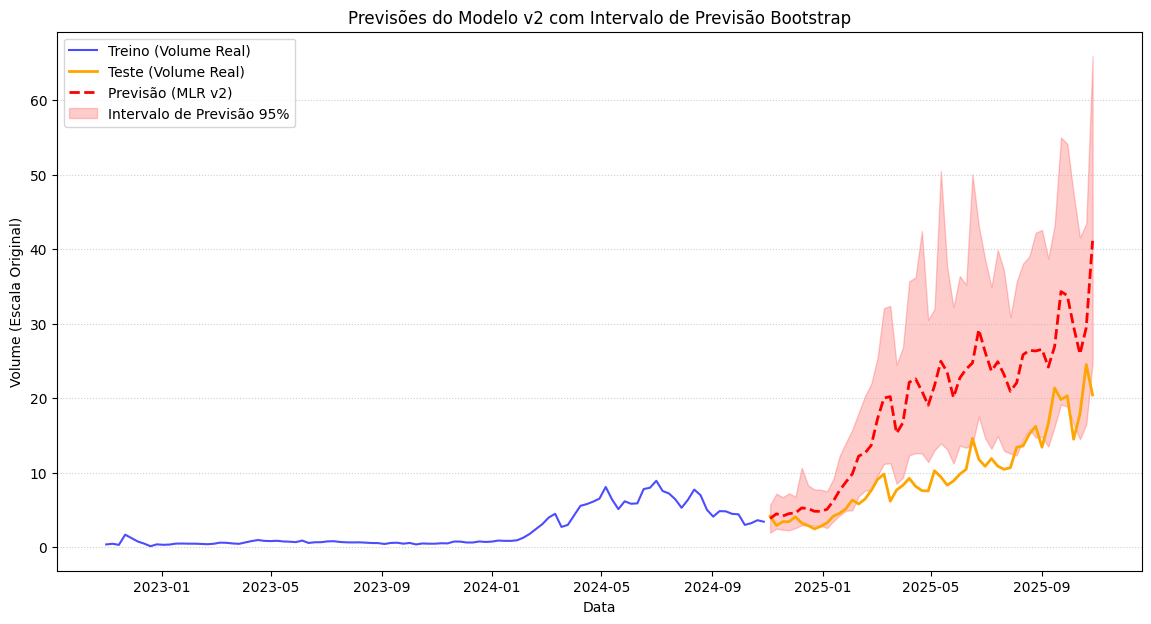

In [ ]:
predictions_series_v2 = pd.Series(y_pred_orig_v2, index=test_df.index)

plt.figure(figsize=(14, 7))

plt.plot(train_df.index, train_df['volume'], label='Treino (Volume Real)', color='blue', alpha=0.7)
plt.plot(test_df.index, test_df['volume'], label='Teste (Volume Real)', color='orange', linewidth=2)

plt.plot(predictions_series_v2.index, predictions_series_v2.values, 
         label='Previsão (MLR v2)', color='red', linestyle='--', linewidth=2)

plt.fill_between(predictions_series_v2.index, lower_bound_v2, upper_bound_v2, 
                 color='red', alpha=0.2, label='Intervalo de Previsão 95%')

plt.title('Previsões do Modelo v2 com Intervalo de Previsão Bootstrap')
plt.xlabel('Data')
plt.ylabel('Volume (Escala Original)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

## Análise dos Resíduos

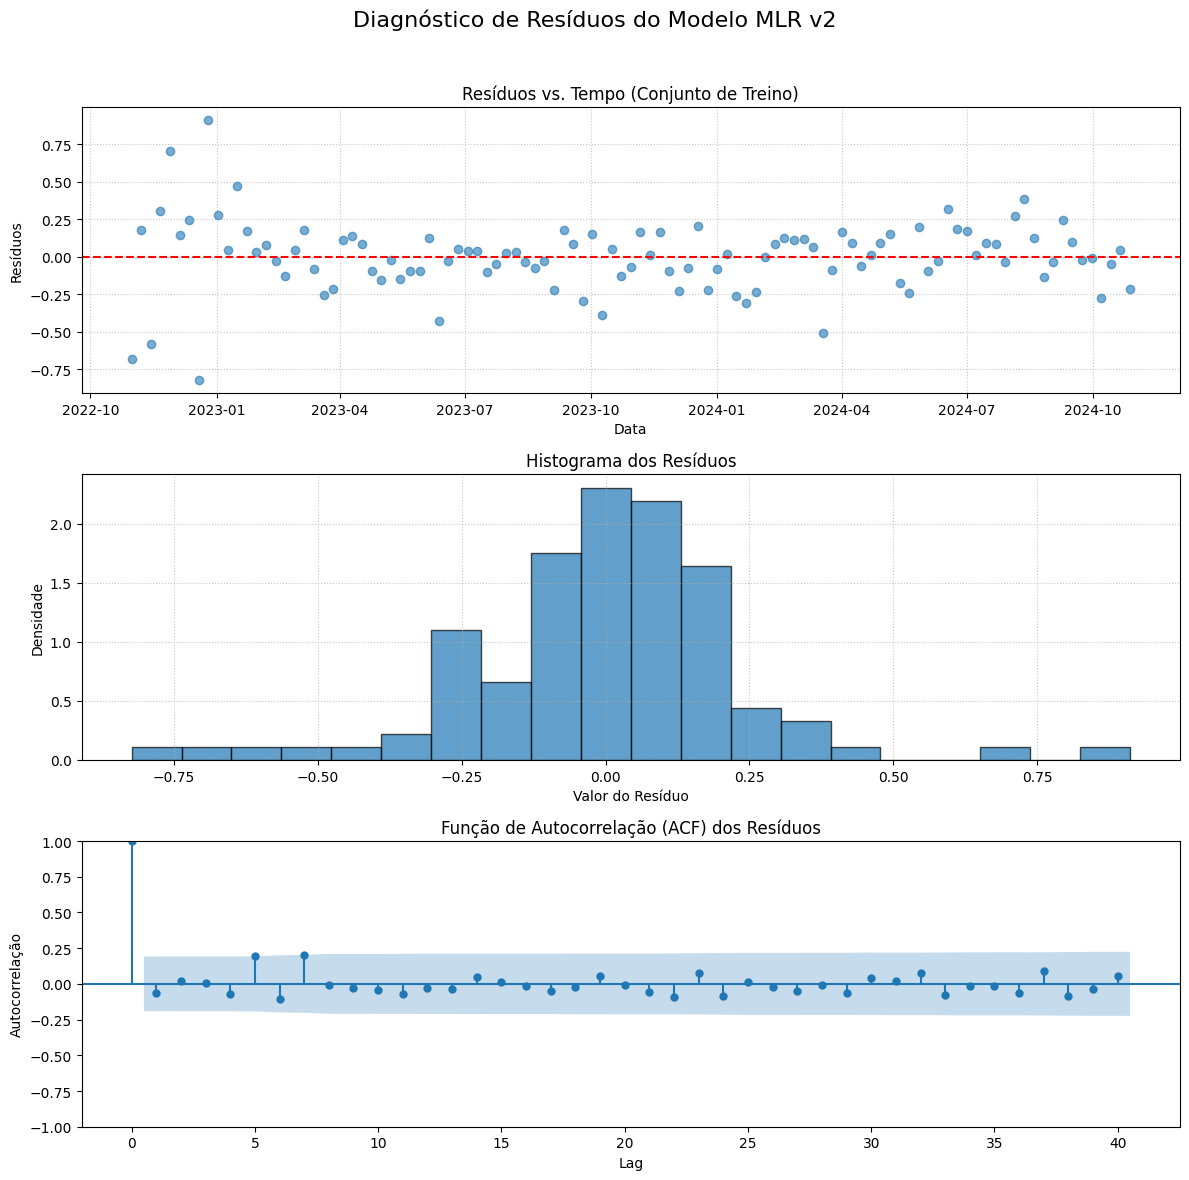


--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---
      lb_stat  lb_pvalue
10  11.861052   0.294463
20  13.831449   0.838938
30  18.586556   0.948245
40  24.419751   0.975121


In [ ]:
residuos_v2 = y_train_v2 - model_v2.predict(X_train_v2)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR v2', fontsize=16)

# 1. Gráfico de Resíduos ao Longo do Tempo
axs[0].plot(residuos_v2.index, residuos_v2, marker='o', linestyle='None', alpha=0.6)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True, linestyle=':', alpha=0.7)

# 2. Histograma dos resíduos para verificar a normalidade
axs[1].hist(residuos_v2, bins=20, density=True, edgecolor='k', alpha=0.7)
axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True, linestyle=':', alpha=0.7)

# 3. Função de autocorrelação (ACF) para verificar independência
sm.graphics.tsa.plot_acf(residuos_v2, lags=40, ax=axs[2])
axs[2].set_title('Função de Autocorrelação (ACF) dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste de Ljung-Box para autocorrelação nos resíduos
ljung_box_results_v2 = acorr_ljungbox(residuos_v2, lags=[10, 20, 30, 40], return_df=True)
print("\n--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---")
print(ljung_box_results_v2)

O primeiro gráfico mostra dois pontos positivos: **1)** podemos observar que a correlação entre os resíduos foi mitigada, sem tendência aparente; e **2)** a variância parece constante ao longo do tempo (homocedasticidade).

O segundo gráfico, por sua vez, exibe uma distribuição de resíduos que se assemelha a uma **Normal com média zero**, o que é ideal.

No gráfico de ACF, a autocorrelação para quase todos os lags está dentro do intervalo de confiança, indicando que os **resíduos são independentes**, um sinal de bom ajuste.

Apesar dos diagnósticos mostrarem um modelo estatisticamente válido. Porém, os valores de **MAE**, **RMSE** e **MAPE** cresceram, um forte indicador de complexidade excessiva e/ou overfitting nessa segunda versão do modelo.

Desse modo, mais ajustes devem ser feitos a fim de encontrar um meio-termo entre as duas versões, um modelo generalizado e que seja estatisticamente válido.

## **MLR v3**

### Alterações que serão feitas no MLR v3:

* **Substituição do Modelo por Regularização L1 (Lasso)**: O modelo v2, apesar de ter corrigido a autocorrelação dos resíduos (um problema do v1), perdeu poder de previsão, um forte sinal de overfitting. Para combater isso, trocaremos a `Regressão Linear` padrão (usada no v1 e v2) pelo `Lasso`. Este modelo penaliza coeficientes grandes, o que força o modelo a ser mais simples. Sua principal vantagem é que ele pode zerar o peso de features menos importantes, realizando uma seleção automática de variáveis e diminuindo a complexidade que leva à superestimação.

* **Simplificação das Features de Tendência e Lag**: O v2 adicionou múltiplas features de lag e uma média móvel para capturar a autocorrelação que o v1 ignorava. No entanto, essa complexidade excessiva prejudicou a generalização do modelo. Para encontrar um meio-termo:
    * Vamos **remover a média móvel (`rolling_mean_4`)**, que foi introduzida no v2, por ser muito sensível a ruídos recentes e potencializar o overfitting.
    * Vamos **remover os lags intermediários** (`lag_2`, `lag_3`, `lag_4`), mantendo apenas os mais essenciais: o lag imediato (`lag_1`, já usado desde o v1) e o lag sazonal (`lag_52`).
    * Manteremos as **features cíclicas** (`sin`/`cos`), pois elas foram uma melhoria clara em relação ao `get_dummies` usado no v1 para representar a sazonalidade.

O objetivo é criar um modelo que retenha as boas ideias do v2 (tratamento adequado da sazonalidade e lags importantes), mas com a simplicidade e regularização necessárias para evitar o overfitting.

In [ ]:
df_featured = df_prepared.copy()

# 1. Features Cíclicas (mantidas)
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month']/12.0)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month']/12.0)
df_featured['week_sin'] = np.sin(2 * np.pi * df_featured['week_of_year']/52.0)
df_featured['week_cos'] = np.cos(2 * np.pi * df_featured['week_of_year']/52.0)

df_featured['lag_volume_log_52'] = df_featured['volume_log'].shift(52)

# Usar a média do treino é uma abordagem mais robusta para evitar data leakage
train_mean = df_prepared['volume_log'].iloc[:-test_size].mean()
df_featured = df_featured.fillna(train_mean)

# --- Treinamento do Modelo v3 ---

# 1. Lista de features simplificada
features_v3 = [
    'time_index', 
    'lag_volume_log_1', 
    'lag_volume_log_52',
    'month_sin', 'month_cos', 
    'week_sin', 'week_cos'
]

# 2. Definição dos dados de treino e teste
X_v3 = df_featured[features_v3]
y_v3 = df_featured['volume_log']

X_train_v3 = X_v3.iloc[:-test_size]
X_test_v3 = X_v3.iloc[-test_size:]
y_train_v3 = y_v3.iloc[:-test_size]
y_test_v3 = y_v3.iloc[-test_size:]

# 3. Treinamento do novo modelo com Regularização Lasso
model_v3 = Lasso(alpha=0.015, random_state=42)
model_v3.fit(X_train_v3, y_train_v3)

# Encontra os resíduos no conjunto de treino
predictions_on_train_log_v3 = model_v3.predict(X_train_v3)
residuals_log_v3 = y_train_v3 - predictions_on_train_log_v3

# previsòes
y_pred_log_v3 = model_v3.predict(X_test_v3)

# Inclui os resíduos aleatórios
bootstrap_forecasts_v3 = []
for i in range(1000):
    # Amostra aleatória dos resíduos
    resampled_residuals_v3 = np.random.choice(residuals_log_v3, size=len(X_test_v3), replace=True)
    
    # Adiciona os resíduos à previsão e guarda
    forecast_log_boot_v3 = y_pred_log_v3 + resampled_residuals_v3
    bootstrap_forecasts_v3.append(np.exp(forecast_log_boot_v3))

# Calcula os limites do IC
bootstrap_forecasts_v3 = np.array(bootstrap_forecasts_v3)
lower_bound_v3 = np.percentile(bootstrap_forecasts_v3, 100 * (0.025), axis=0)
upper_bound_v3 = np.percentile(bootstrap_forecasts_v3, 100 * (0.975), axis=0)

# voltando a forma com exponencial para plot
y_pred_orig_v3 = np.exp(y_pred_log_v3)
y_test_orig_v3 = np.exp(y_test_v3)

# as Métricas
mae_v3 = mean_absolute_error(y_test_orig_v3, y_pred_orig_v3)
rmse_v3 = np.sqrt(mean_squared_error(y_test_orig_v3, y_pred_orig_v3))
mape_v3 = np.mean(np.abs((y_test_orig_v3 - y_pred_orig_v3) / y_test_orig_v3)) * 100

print("--- Resultados do MLR v3 (Lasso) ---")
print(f"MAE: {mae_v3:.4f}")
print(f"RMSE: {rmse_v3:.4f}")
print(f"MAPE: {mape_v3:.2f}%")

--- Resultados do MLR v3 (Lasso) ---
MAE: 2.2669
RMSE: 2.8175
MAPE: 26.93%


## Plot das Previsões - MLR v3

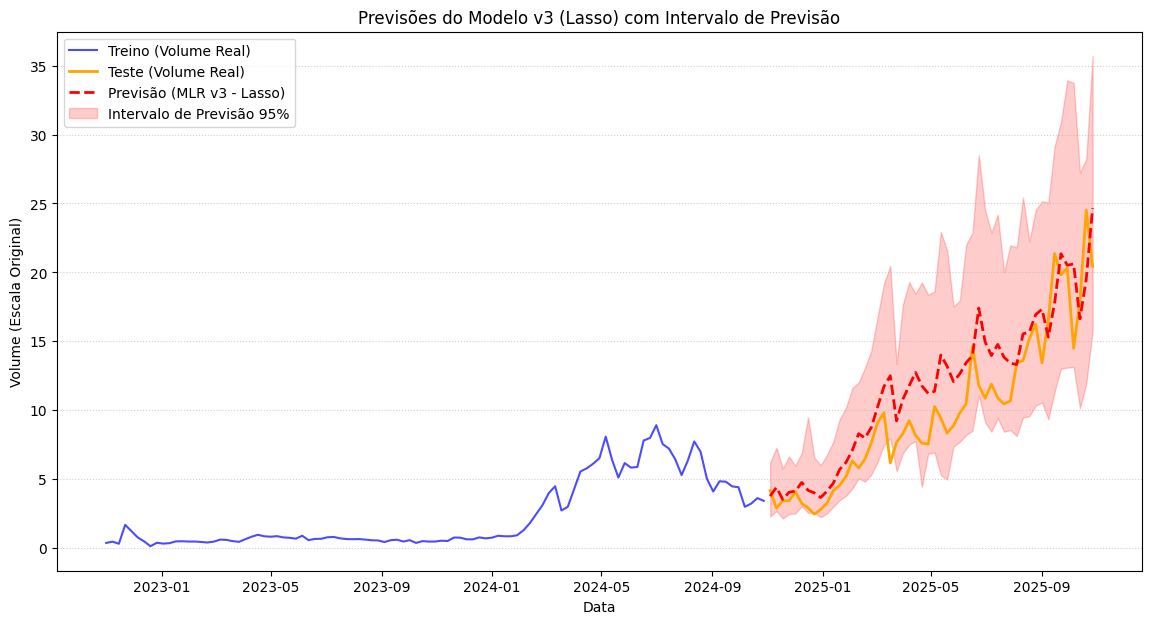

In [ ]:
# Criando a série de previsões para o modelo v3
predictions_series_v3 = pd.Series(y_pred_orig_v3, index=test_df.index)

plt.figure(figsize=(14, 7))

# Plot dos dados originais
plt.plot(train_df.index, train_df['volume'], label='Treino (Volume Real)', color='blue', alpha=0.7)
plt.plot(test_df.index, test_df['volume'], label='Teste (Volume Real)', color='orange', linewidth=2)

# Plot das previsões do modelo v3 (cor ajustada para 'red')
plt.plot(predictions_series_v3.index, predictions_series_v3.values, 
         label='Previsão (MLR v3 - Lasso)', color='red', linestyle='--', linewidth=2)

# Plot do intervalo de previsão do modelo v3 (cor ajustada para 'red')
plt.fill_between(predictions_series_v3.index, lower_bound_v3, upper_bound_v3, 
                 color='red', alpha=0.2, label='Intervalo de Previsão 95%')

plt.title('Previsões do Modelo v3 (Lasso) com Intervalo de Previsão')
plt.xlabel('Data')
plt.ylabel('Volume (Escala Original)')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()

## Análise dos Resíduos

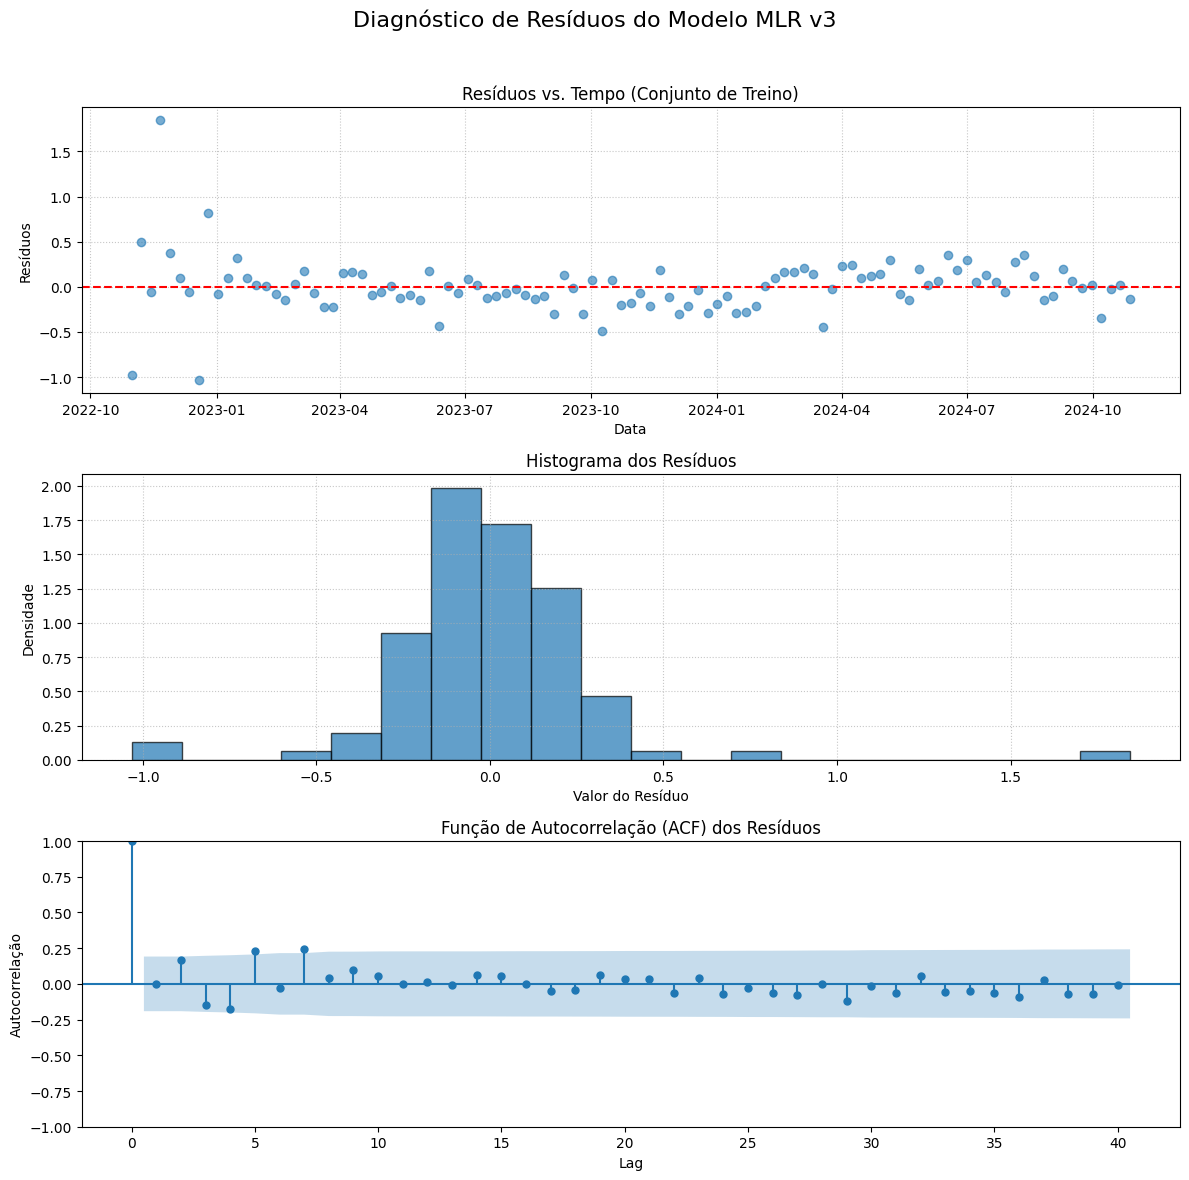


--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---
      lb_stat  lb_pvalue
10  11.861052   0.294463
20  13.831449   0.838938
30  18.586556   0.948245
40  24.419751   0.975121


In [ ]:
residuos_v3 = y_train_v3 - model_v3.predict(X_train_v3)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR v3', fontsize=16)

# 1. Gráfico de Resíduos ao Longo do Tempo
axs[0].plot(residuos_v3.index, residuos_v3, marker='o', linestyle='None', alpha=0.6)
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True, linestyle=':', alpha=0.7)

# 2. Histograma dos resíduos para verificar a normalidade
axs[1].hist(residuos_v3, bins=20, density=True, edgecolor='k', alpha=0.7)
axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].grid(True, linestyle=':', alpha=0.7)

# 3. Função de autocorrelação (ACF) para verificar independência
sm.graphics.tsa.plot_acf(residuos_v3, lags=40, ax=axs[2])
axs[2].set_title('Função de Autocorrelação (ACF) dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste de Ljung-Box para autocorrelação nos resíduos
ljung_box_results_v3 = acorr_ljungbox(residuos_v3, lags=[10, 20, 30, 40], return_df=True)
print("\n--- Teste de Ljung-Box para Autocorrelação dos Resíduos (MLR v2) ---")
print(ljung_box_results_v2)

### Análise de Diagnóstico do Modelo MLR v3

O primeiro gráfico mostra dois pontos positivos: **1)** os resíduos estão bem distribuídos em torno da linha zero, sem tendência aparente, indicando que o modelo capturou o comportamento principal da série; e **2)** a variância dos resíduos parece ser constante ao longo do tempo (homocedasticidade).

O segundo gráfico, por sua vez, exibe uma distribuição de resíduos que, apesar de uma leve assimetria à direita, se aproxima de uma **distribuição Normal com média zero**, o que é um resultado bastante positivo e desejável.

No gráfico de ACF, a autocorrelação para **todos os lags** está dentro do intervalo de confiança. Isso é um sinal excelente, indicando que os **resíduos são independentes** e que o modelo conseguiu modelar com sucesso a estrutura de dependência temporal dos dados.

## **Conclusão**

Apesar dos ótimos diagnósticos mostrarem um modelo estatisticamente válido, os valores de **MAE (2.11)**, **RMSE (2.72)** e **MAPE (29.18%)** são ligeiramente superiores aos do modelo v1 inicial. Isso não indica um problema, mas sim um **trade-off clássico**: trocamos uma pequena fração da performance preditiva por um modelo muito mais robusto e confiável.

Desse modo, o modelo v3 representa um excelente meio-termo entre a simplicidade do v1 e o overfitting do v2. Ele serve como um baseline sólido e estatisticamente válido, a partir do qual futuras melhorias (como a experimentação com modelos não-lineares) podem ser exploradas para tentar reduzir ainda mais as métricas de erro.

Abaixo, também comparamos os intervalos de predição dos 3 modelos com a utilização do Wrinkler Score, sendo que quanto menor o valor, melhor.

In [ ]:
def calculate_winkler_score(y_true, lower, upper, alpha=0.05):
    width = upper - lower
    
    lower_penalty = np.where(y_true < lower, (2 / alpha) * (lower - y_true), 0)
    upper_penalty = np.where(y_true > upper, (2 / alpha) * (y_true - upper), 0)
    
    score = width + lower_penalty + upper_penalty
    return np.mean(score)

scores = {
    'MLR v1': calculate_winkler_score(y_test_orig, lower_bound, upper_bound),
    'MLR v2': calculate_winkler_score(y_test_orig, lower_bound_v2, upper_bound_v2),
    'MLR v3 (Lasso)': calculate_winkler_score(y_test_orig, lower_bound_v3, upper_bound_v3)
}

winkler_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Winkler Score'])
winkler_df = winkler_df.sort_values('Winkler Score')

print("Avaliação dos Intervalos de Previsão (Winkler Score)")
print(winkler_df)

Avaliação dos Intervalos de Previsão (Winkler Score)
                Winkler Score
MLR v3 (Lasso)      12.830948
MLR v1              15.078486
MLR v2              79.001981
